In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\moral005\Dropbox\Panda\WORK\Research\FSPM\Virtual_Plant_Laboratory\Julia\VPLsite\tutorials\snowflakes"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using VPL
module sn
    import VPL
    struct E <: VPL.Node
        length::Float64
    end
end
import .sn

In [3]:
const L = 1.0
axiom = sn.E(L) + VPL.RU(120.0) + sn.E(L) + VPL.RU(120.0) + sn.E(L)

VPL.Core.StaticGraph(Dict{Int64, Any}(5 => VPL.Core.GraphNode{Main.sn.E}(Main.sn.E(1.0), Set{Int64}(), 4, 5), 4 => VPL.Core.GraphNode{VPL.Geom.RU{Float64}}(VPL.Geom.RU{Float64}(120.0), Set([5]), 3, 4), 2 => VPL.Core.GraphNode{VPL.Geom.RU{Float64}}(VPL.Geom.RU{Float64}(120.0), Set([3]), 1, 2), 3 => VPL.Core.GraphNode{Main.sn.E}(Main.sn.E(1.0), Set([4]), 2, 3), 1 => VPL.Core.GraphNode{Main.sn.E}(Main.sn.E(1.0), Set([2]), missing, 1)), Dict{DataType, Set{Int64}}(VPL.Geom.RU{Float64} => Set([4, 2]), Main.sn.E => Set([5, 3, 1])), 1, 5)

In [4]:
function Kochsnowflake(x)
    L = data(x).length
    sn.E(L/3) + RU(-60.0) + sn.E(L/3) + RU(120.0) + sn.E(L/3) + RU(-60.0) + sn.E(L/3)
 end
 rule = Rule(sn.E, rhs = Kochsnowflake)

Rule replacing nodes of type Main.sn.E without context capturing.


In [5]:
Koch = Graph(axiom = axiom, rules = Tuple(rule))

Dynamic graph with 5 nodes of types VPL.Geom.RU{Float64},Main.sn.E and 1 rewriting rules.


In [6]:
function VPL.feed!(turtle::MTurtle, e::sn.E)
    HollowCylinder!(turtle, length = e.length, width = e.length/10, height = e.length/10, move = true)
    return nothing
end

In [7]:
function VPL.feedcolor!(turtle::GLTurtle, e::sn.E)
    feedcolor!(turtle, RGB(rand(), rand(), rand()))
    return nothing
end

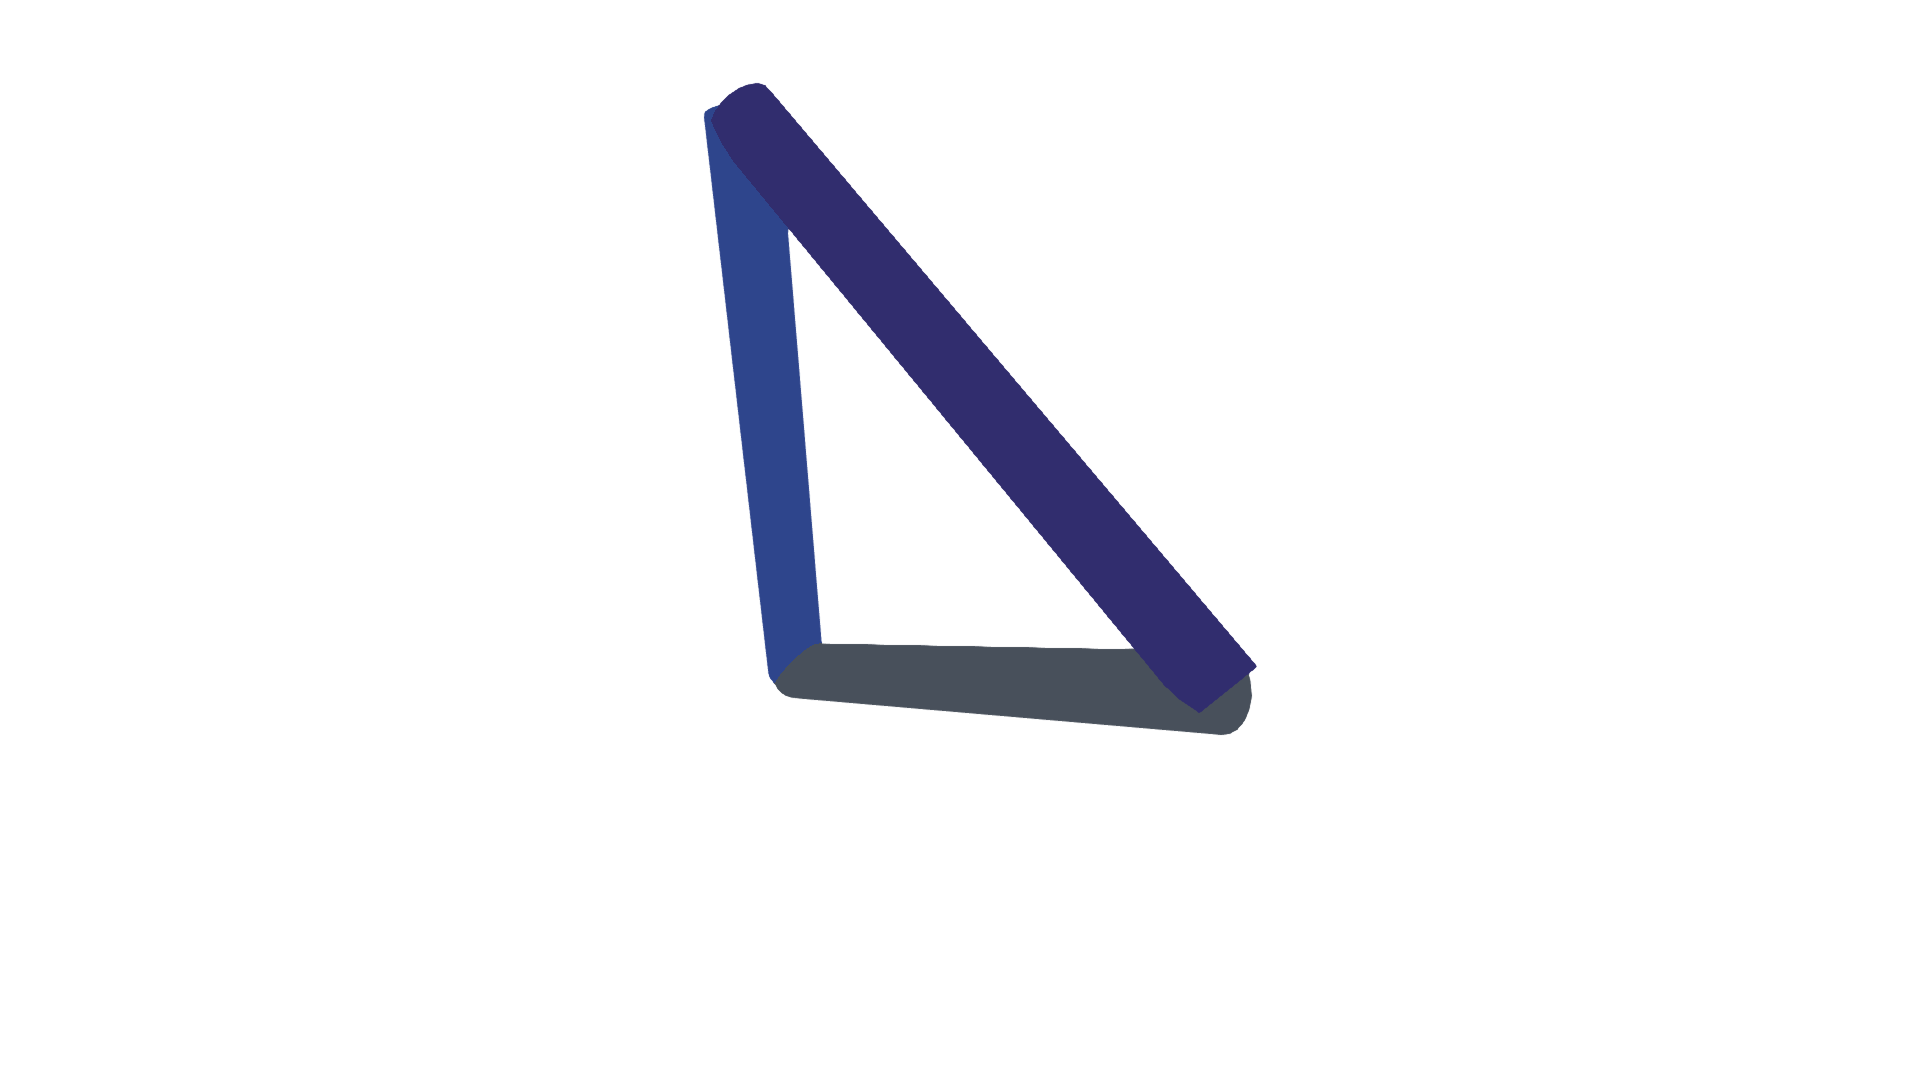

In [8]:
render(Koch, axes = false)

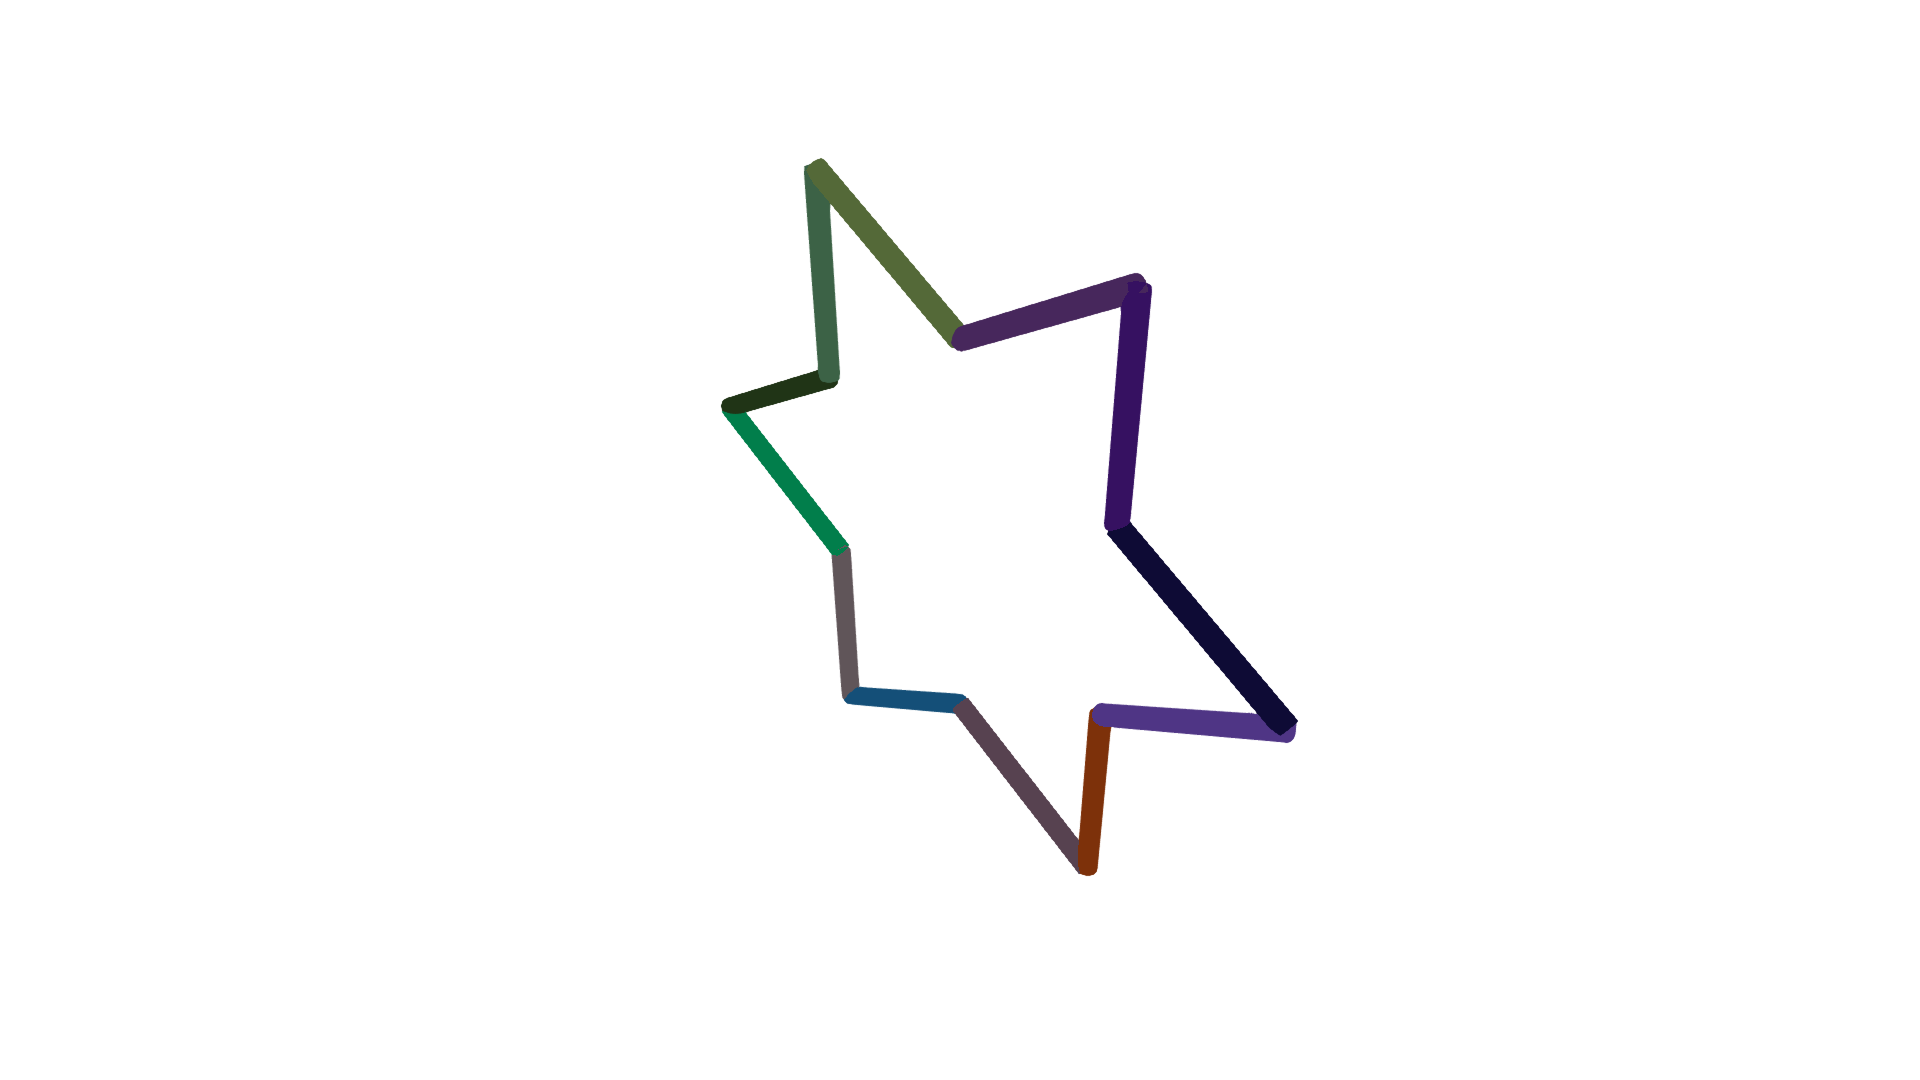

In [9]:
rewrite!(Koch)
render(Koch, axes = false)

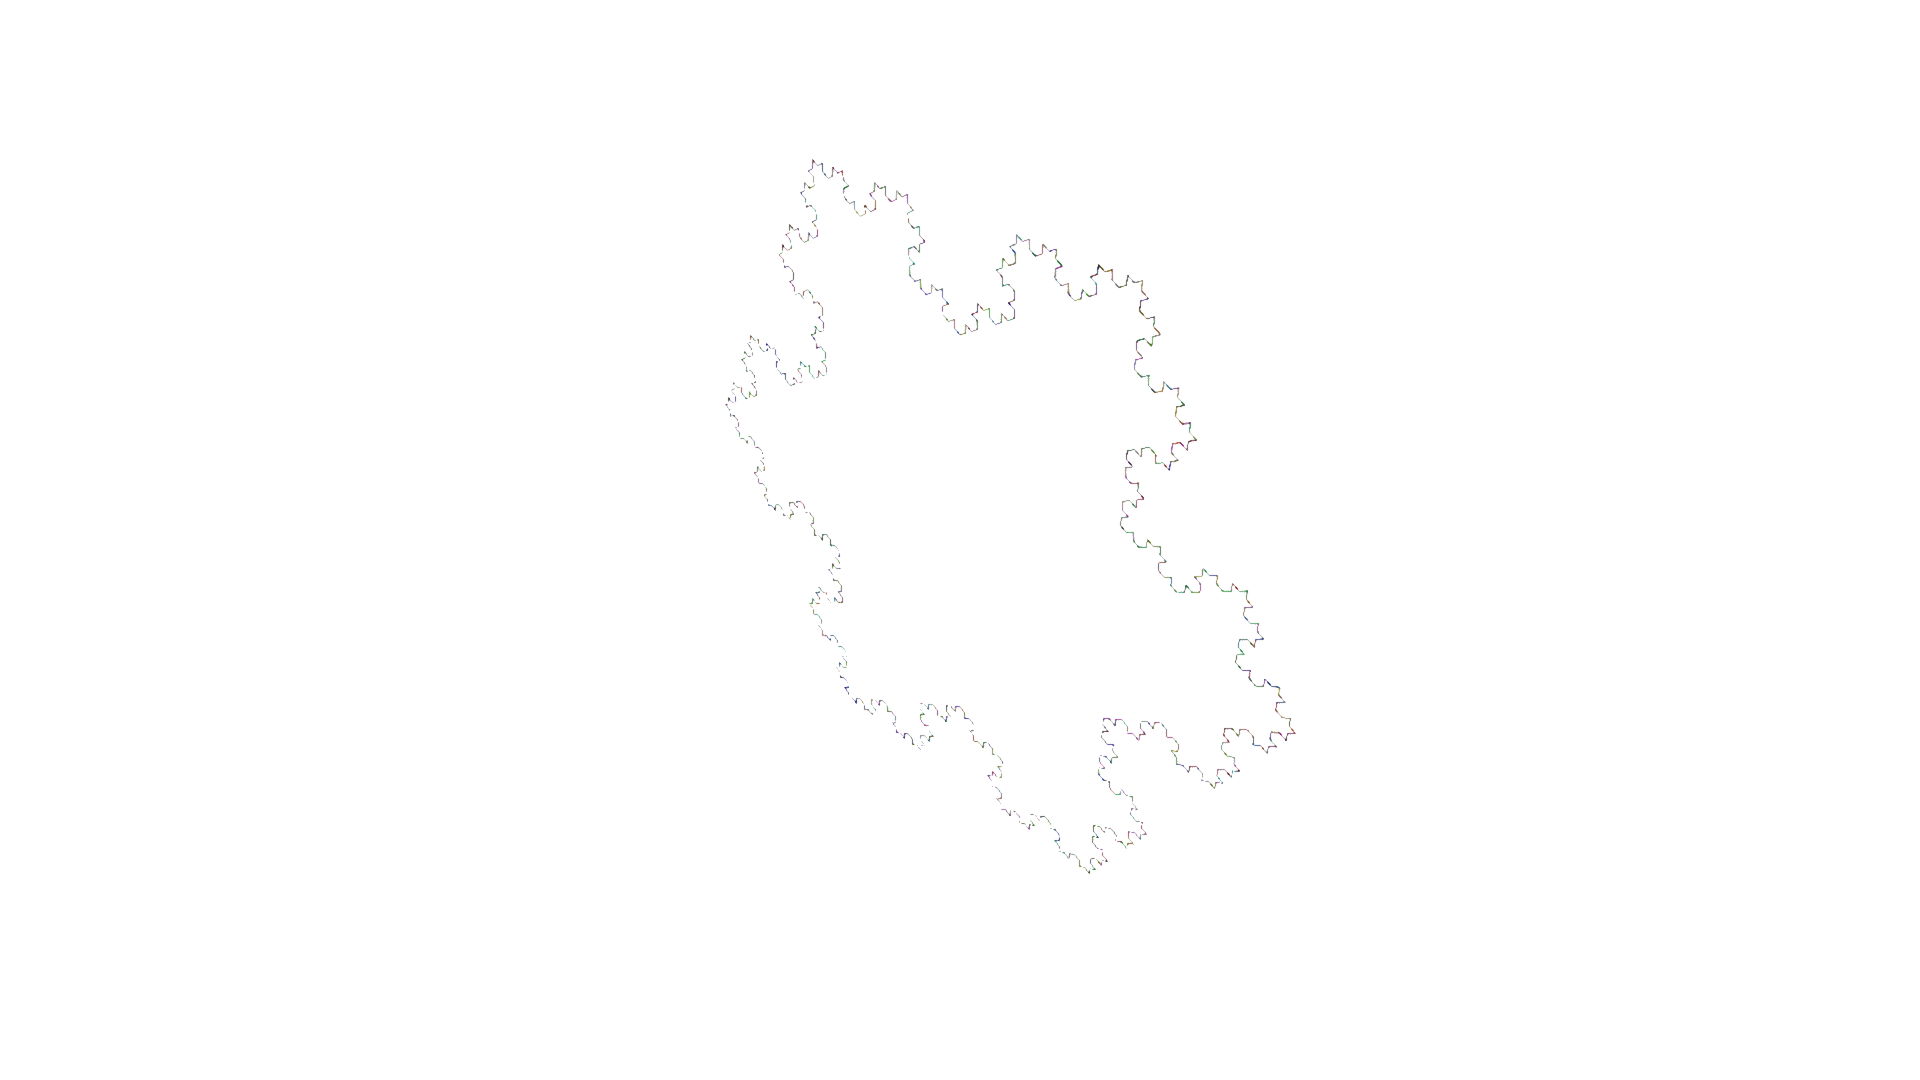

In [10]:
for i in 1:3
    rewrite!(Koch)
end
render(Koch, axes = false)

In [11]:
function Kochsnowflake2(x)
   L = data(x).length
   sn.E(L/3) + RU(60.0) + sn.E(L/3) + RU(-120.0) + sn.E(L/3) + RU(60.0) + sn.E(L/3)
end
rule2 = Rule(sn.E, rhs = Kochsnowflake2)
Koch2 = Graph(axiom = axiom, rules = Tuple(rule2))

Dynamic graph with 5 nodes of types VPL.Geom.RU{Float64},Main.sn.E and 1 rewriting rules.


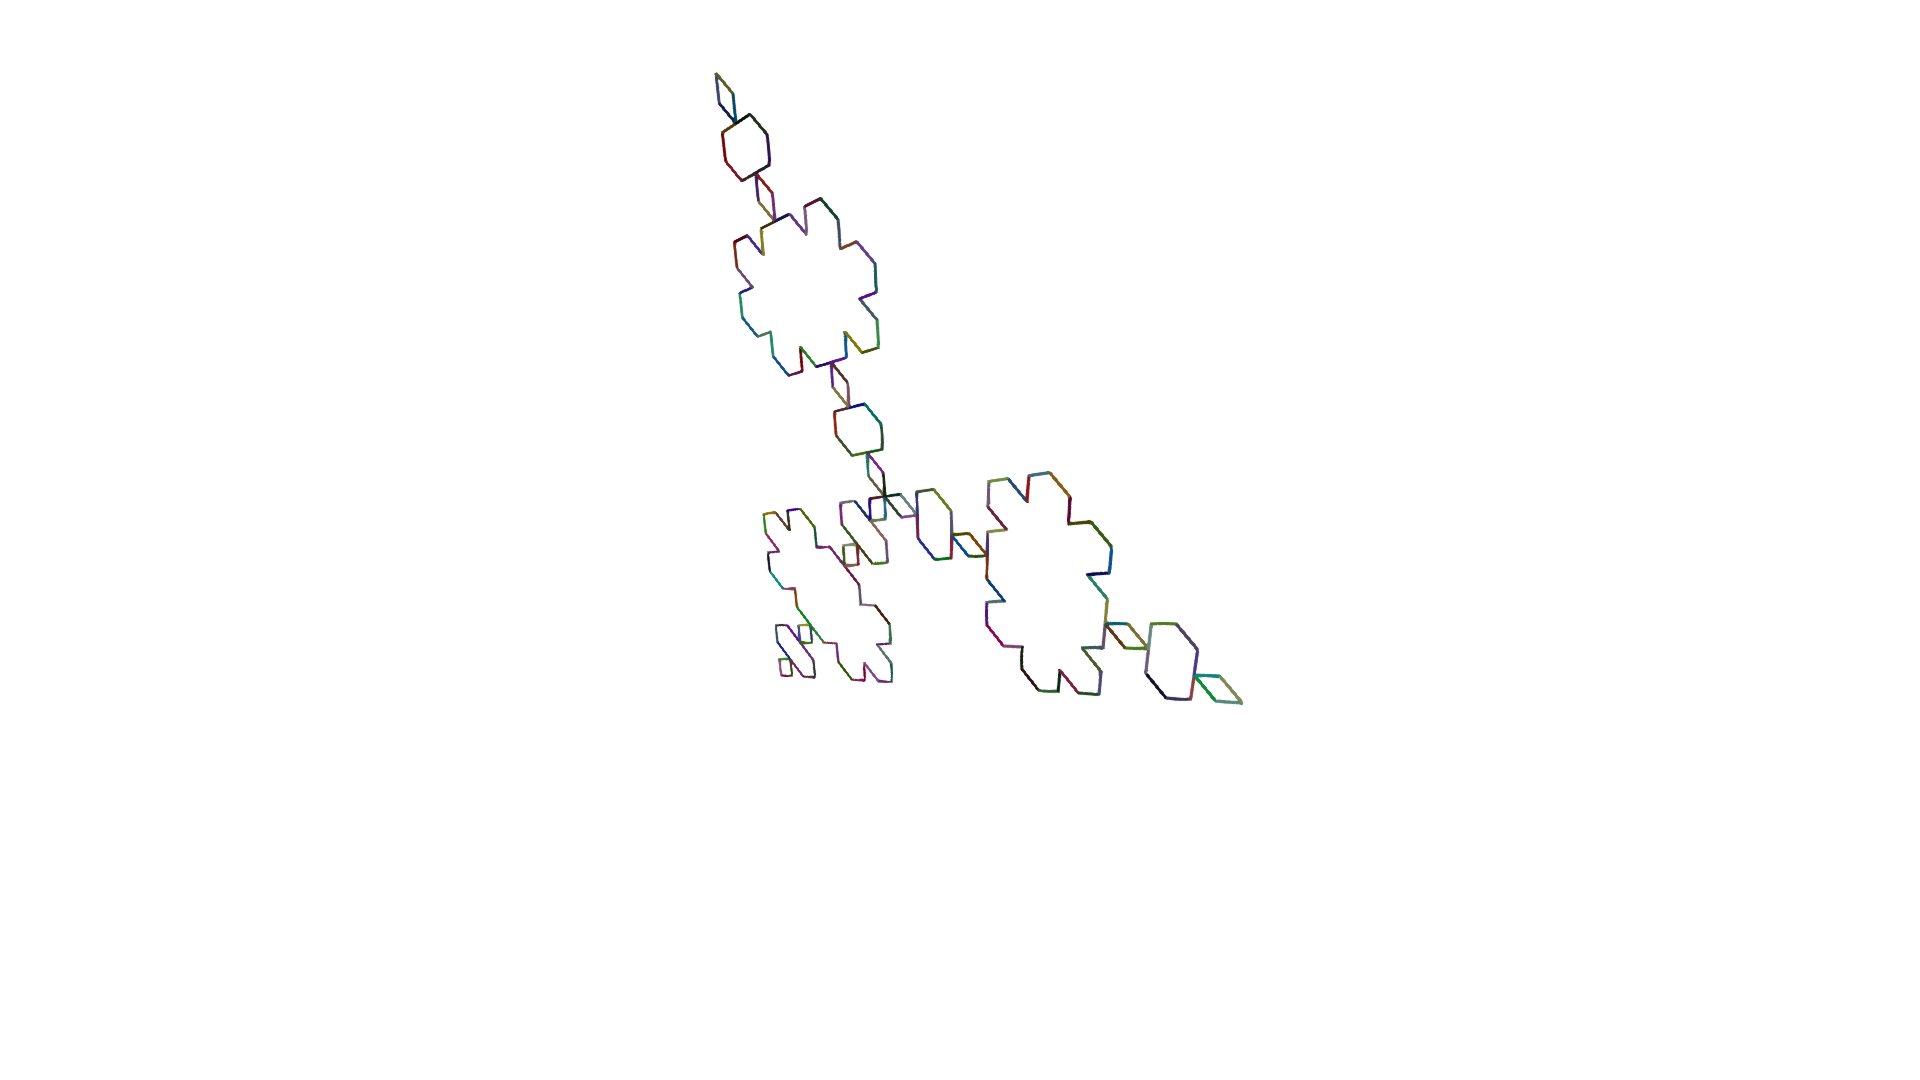

In [12]:
# First iteration
rewrite!(Koch2)
render(Koch2, axes = false)
# Second iteration
rewrite!(Koch2)
render(Koch2, axes = false)
# Third iteration
rewrite!(Koch2)
render(Koch2, axes = false)

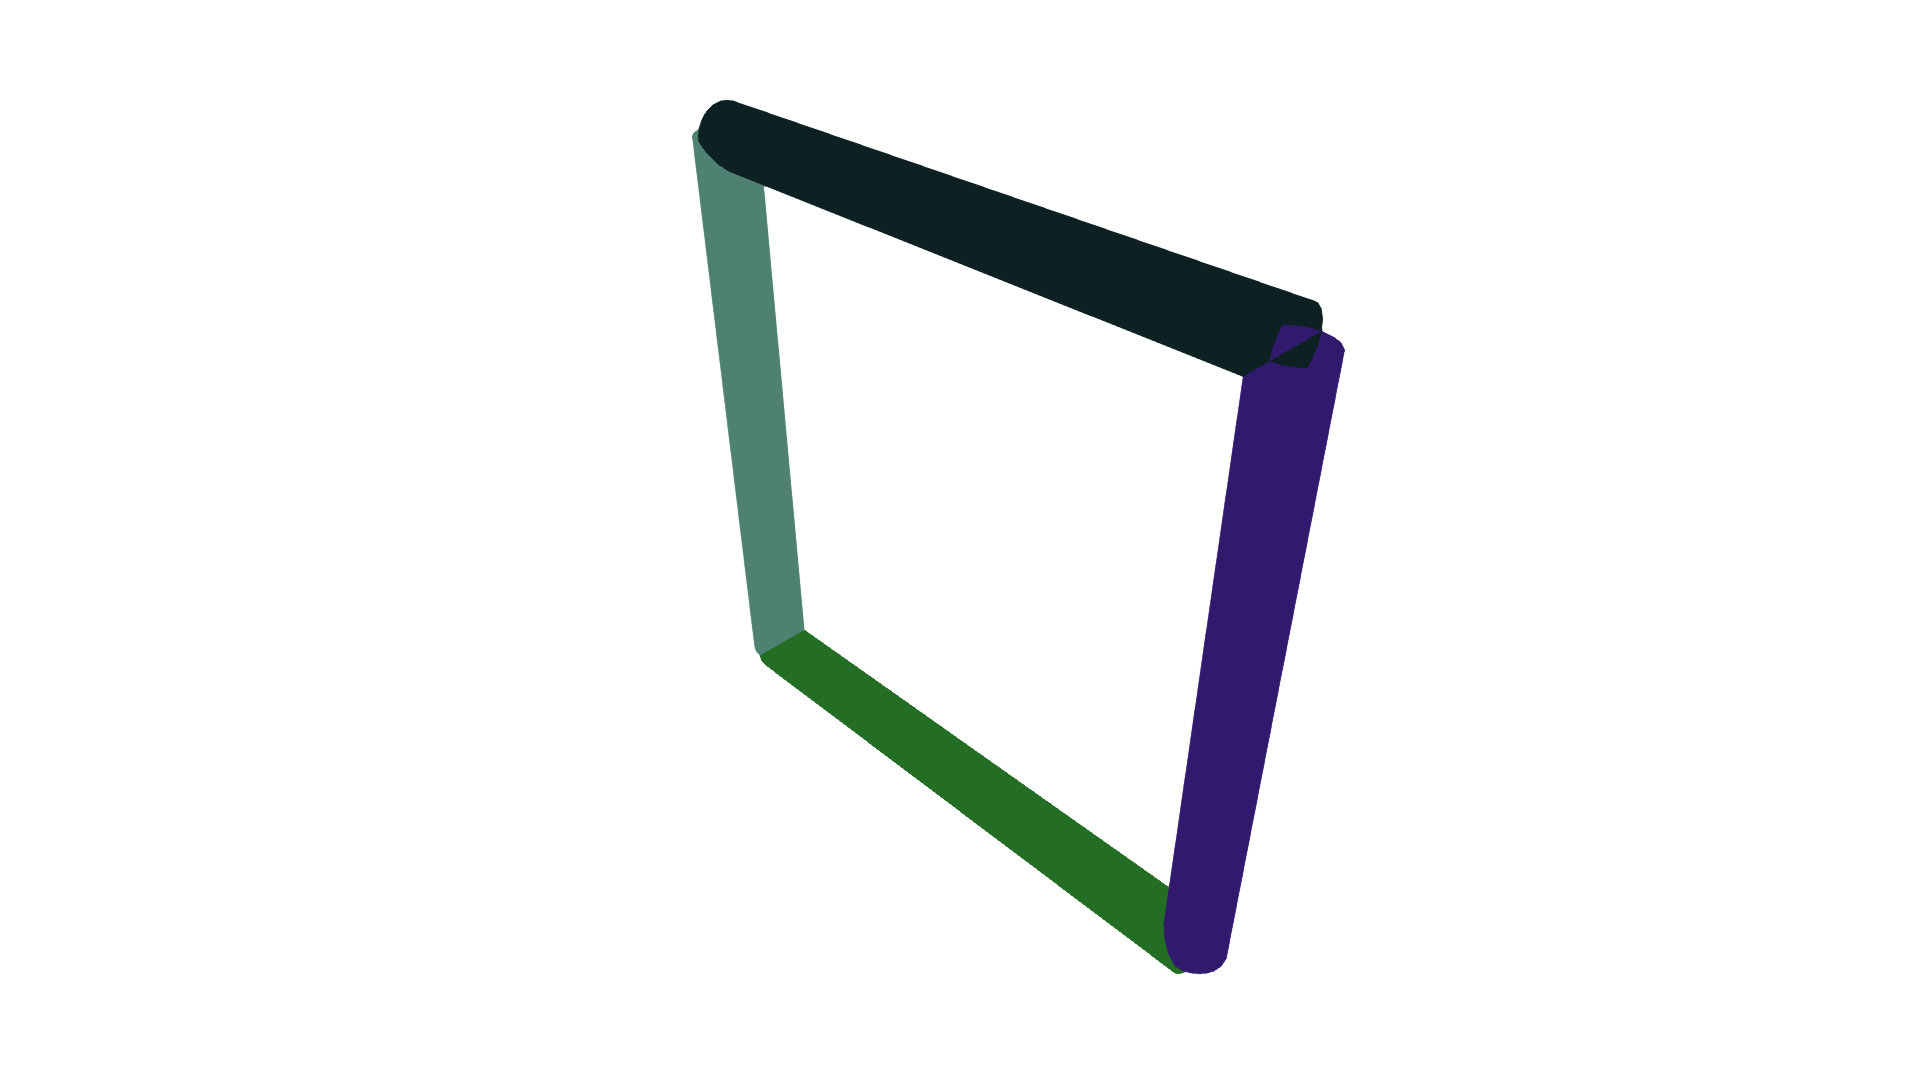

In [13]:
axiomCesaro = sn.E(L) + RU(90.0) + sn.E(L) + RU(90.0) + sn.E(L) + RU(90.0) + sn.E(L)
Cesaro = Graph(axiom = axiomCesaro, rules = (rule2,))
render(Cesaro, axes = false)

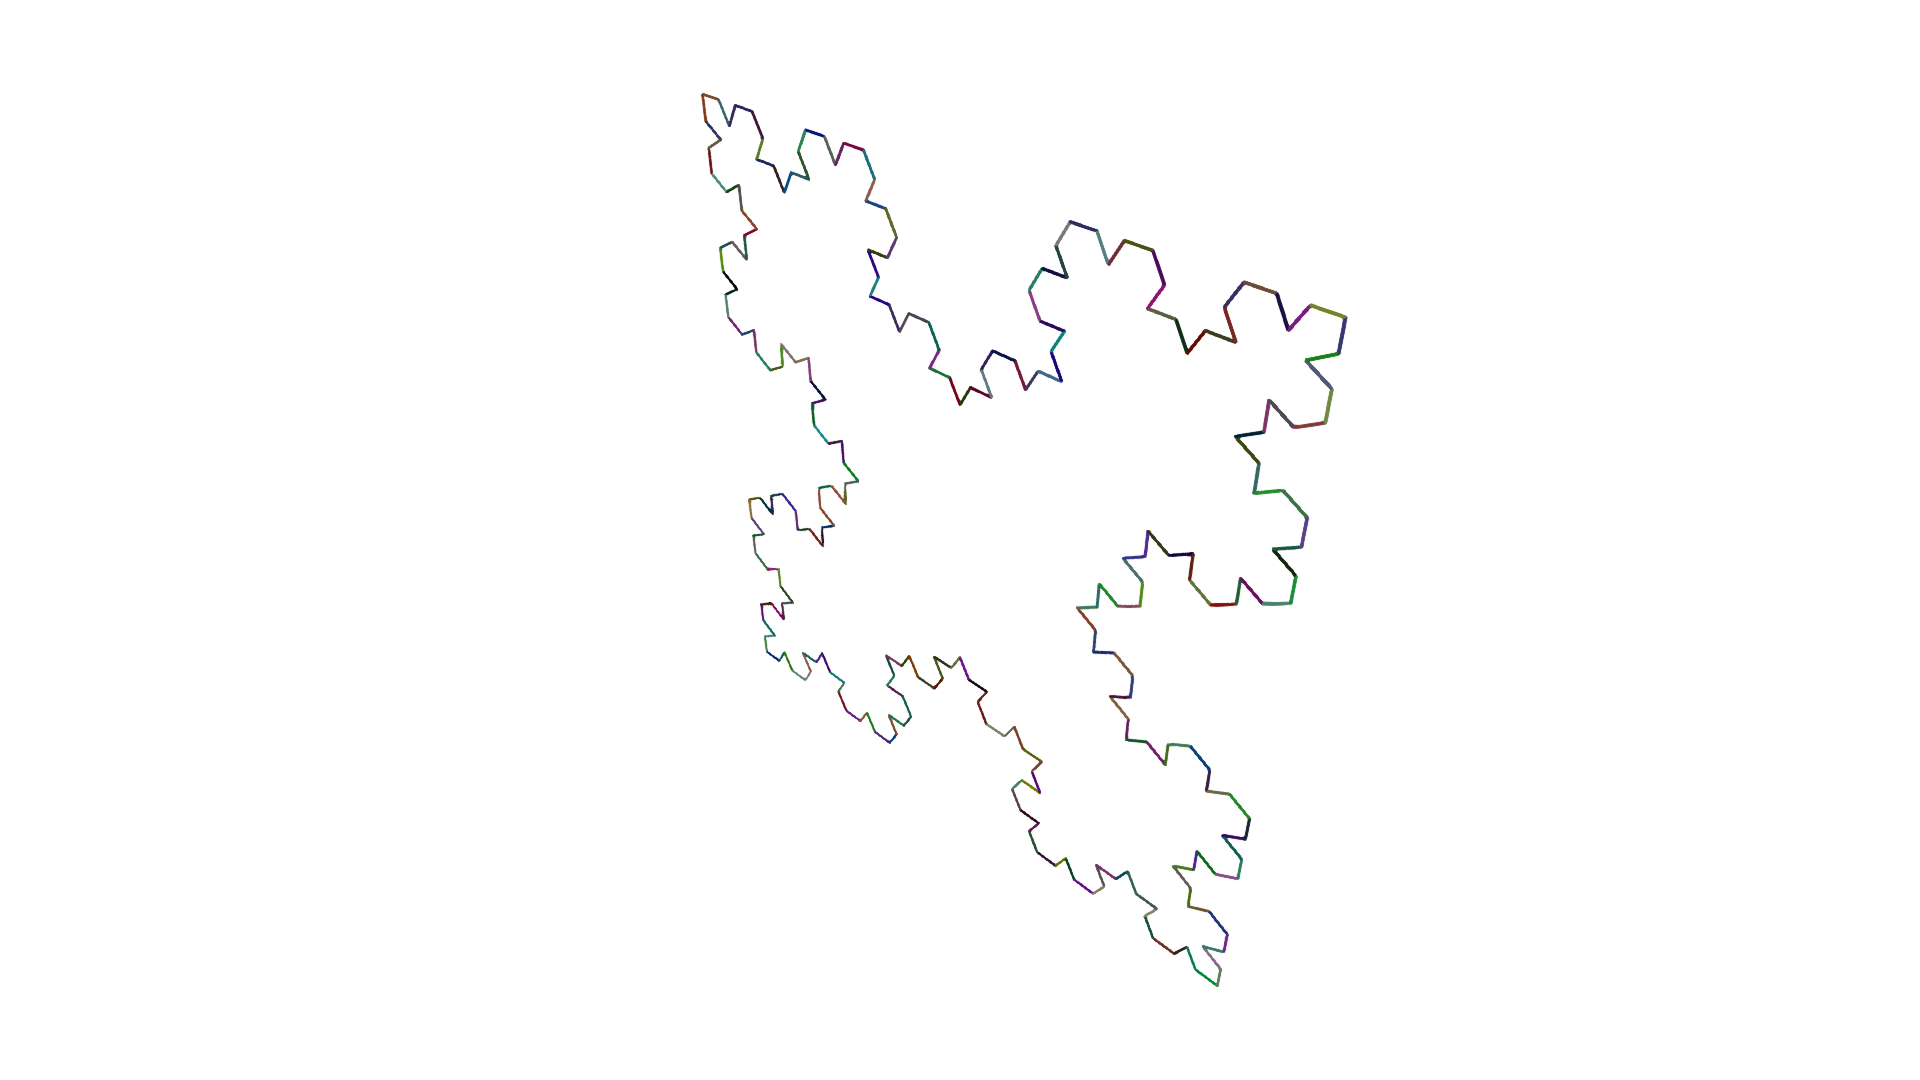

In [14]:
# First iteration
rewrite!(Cesaro)
render(Cesaro, axes = false)
# Second iteration
rewrite!(Cesaro)
render(Cesaro, axes = false)
# Third iteration
rewrite!(Cesaro)
render(Cesaro, axes = false)